In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-transpiler-service
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.5/541.5 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.1.1
    Uninstalling qiskit-2.1.1:
      Successfully uninstalled qiskit-2.1.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 596.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=d8a0e

In [15]:
def QFT(n):
    """n-qubit QFT circuit"""
    qc = QuantumCircuit(n)

    # Apply swaps at the end to reverse qubit order
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)

    # Apply controlled rotations and Hadamards
    for j in reversed(range(n)):
        qc.h(j)
        for k in reversed(range(j)):
            qc.cp(np.pi/2**(j-k), k, j)

    return qc

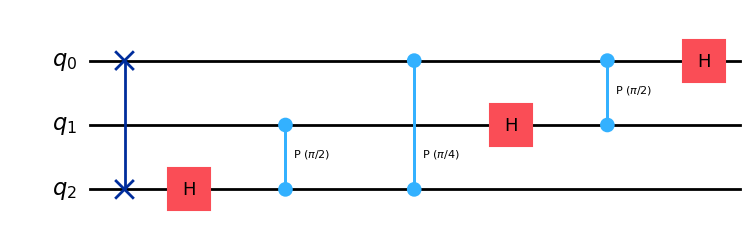

In [16]:
qc=QFT(3)
qc.draw('mpl')

In [17]:
#IQFT
def inverse_qft(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    return qc

In [18]:
qc2=inverse_qft(3)

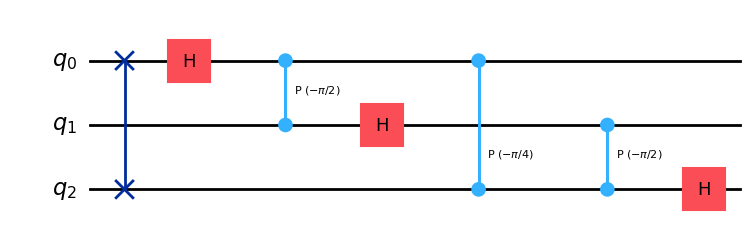

In [19]:
qc2.draw('mpl')

In [23]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

Phase Estimation Circuit:
     ┌───┐                                                 ┌──────┐┌─┐      
q_0: ┤ H ├─■───────────────────────────────────────────────┤0     ├┤M├──────
     ├───┤ │                                               │      │└╥┘┌─┐   
q_1: ┤ H ├─┼──────■──────■─────────────────────────────────┤1 QFT ├─╫─┤M├───
     ├───┤ │      │      │                                 │      │ ║ └╥┘┌─┐
q_2: ┤ H ├─┼──────┼──────┼──────■──────■──────■──────■─────┤2     ├─╫──╫─┤M├
     ├───┤ │P(π)  │P(π)  │P(π)  │P(π)  │P(π)  │P(π)  │P(π) └──────┘ ║  ║ └╥┘
q_3: ┤ X ├─■──────■──────■──────■──────■──────■──────■──────────────╫──╫──╫─
     └───┘                                                          ║  ║  ║ 
c: 3/═══════════════════════════════════════════════════════════════╩══╩══╩═
                                                                    0  1  2 

Measurement results: {'100': 1024}


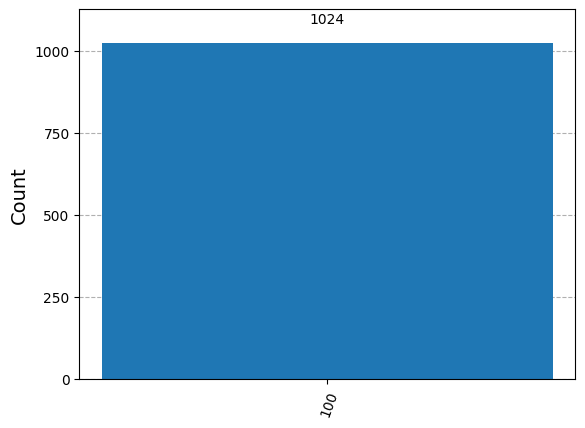


Phase Estimation Results:
Most frequent measurement: 100 (binary)
Estimated phase: θ = 0.5
Corresponding eigenvalue: e^(i2πθ) = (-1+1.2246467991473532e-16j)
Expected phase for Z|1⟩: 0.5 (since Z|1⟩ = -|1⟩ = e^(iπ)|1⟩)


In [26]:
#QPE Algorithm
def phase_estimation_Z():
    n_counting = 3
    qpe = QuantumCircuit(n_counting + 1, n_counting)
    qpe.x(n_counting)
    qpe.h(range(n_counting))

    for counting_qubit in range(n_counting):

        for _ in range(2**counting_qubit):
            qpe.cp(np.pi, counting_qubit, n_counting)

    qpe.append(QFT(n_counting), range(n_counting))

    qpe.measure(range(n_counting), range(n_counting))

    print("Phase Estimation Circuit:")
    print(qpe.draw())

    simulator = AerSimulator()

    transpiled_qpe = transpile(qpe, simulator)

    result = simulator.run(transpiled_qpe, shots=1024).result()
    counts = result.get_counts()
    print("\nMeasurement results:", counts)
    display(plot_histogram(counts))

    measured_binary = max(counts, key=counts.get)
    measured_phase = int(measured_binary, 2)/(2**n_counting)

    print("\nPhase Estimation Results:")
    print(f"Most frequent measurement: {measured_binary} (binary)")
    print(f"Estimated phase: θ = {measured_phase}")
    print(f"Corresponding eigenvalue: e^(i2πθ) = {np.exp(1j*2*np.pi*measured_phase)}")
    print(f"Expected phase for Z|1⟩: 0.5 (since Z|1⟩ = -|1⟩ = e^(iπ)|1⟩)")

phase_estimation_Z()